In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA 

In [123]:
customer = pd.read_excel('CustomersData.xlsx')
discount = pd.read_csv('Discount_Coupon.csv')
spend = pd.read_csv('Marketing_Spend.csv')
sale = pd.read_csv('Online_Sales.csv')
tax = pd.read_excel('Tax_amount.xlsx')

In [124]:
sale_dis = pd.merge(left=sale, right=discount, how='left', left_on='Product_Category', right_on='Product_Category ')
sale_d_t = pd.merge(left=sale_dis, right=tax, how='left', left_on='Product_Category', right_on='Product_Category')
df = pd.merge(left=sale_d_t, right=customer, how='left', left_on='CustomerID', right_on='CustomerID')

In [125]:
df1 = df.groupby('CustomerID', as_index=False)[['Quantity','Avg_Price','Delivery_Charges','Discount_pct','GST']].sum()

In [126]:
final_df = pd.merge(left=df1, right=customer, how='left', left_on='CustomerID', right_on='CustomerID')

In [127]:
final_df

,CustomerID,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Gender,Location,Tenure_Months
0,12346,36,305.88,1800.00,480.0,3.36,F,New York,31
1,12347,4082,44830.83,7910.18,14160.0,92.14,M,New York,20
2,12348,2508,4038.24,2365.80,5520.0,41.04,M,California,39
3,12350,252,15748.80,1534.56,4080.0,25.92,M,California,25
4,12356,672,14937.96,7649.88,8640.0,64.08,F,Chicago,31
...,...,...,...,...,...,...,...,...,...
1463,18259,541,823.27,3268.46,1440.0,11.58,F,California,5
1464,18260,1549,13339.08,7387.08,9360.0,62.94,M,New York,43
1465,18269,120,1072.08,618.00,1920.0,16.32,M,Chicago,25
1466,18277,24,1788.00,72.00,240.0,1.20,F,Chicago,47


In [128]:
## One hot encoding
df_new = pd.get_dummies(final_df, columns=['Gender'], drop_first=True, prefix='gender')

In [129]:
df_new = pd.get_dummies(df_new, columns=['Location'], drop_first=True, prefix='location')

In [130]:
df_new

,CustomerID,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Tenure_Months,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC
0,12346,36,305.88,1800.00,480.0,3.36,31,0,0,0,1,0
1,12347,4082,44830.83,7910.18,14160.0,92.14,20,1,0,0,1,0
2,12348,2508,4038.24,2365.80,5520.0,41.04,39,1,0,0,0,0
3,12350,252,15748.80,1534.56,4080.0,25.92,25,1,0,0,0,0
4,12356,672,14937.96,7649.88,8640.0,64.08,31,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1463,18259,541,823.27,3268.46,1440.0,11.58,5,0,0,0,0,0
1464,18260,1549,13339.08,7387.08,9360.0,62.94,43,1,0,0,1,0
1465,18269,120,1072.08,618.00,1920.0,16.32,25,1,1,0,0,0
1466,18277,24,1788.00,72.00,240.0,1.20,47,0,1,0,0,0


In [131]:
df_new = df_new.drop(columns = ['CustomerID'])

In [132]:
df_new.isnull().count()

Quantity                  1468
Avg_Price                 1468
Delivery_Charges          1468
Discount_pct              1468
GST                       1468
Tenure_Months             1468
gender_M                  1468
location_Chicago          1468
location_New Jersey       1468
location_New York         1468
location_Washington DC    1468
dtype: int64

In [133]:
#Handling Outliers 
def outlier_capping(x):
    #x = x.clip_upper(x.quantile(0.99))
    #x = x.clip_lower(x.quantile(0.01))
    x = x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99))
    return x

df_new=df_new.apply(lambda x: outlier_capping(x))

In [134]:
## Standardize data
sc = StandardScaler()

In [135]:
std_data = sc.fit(df_new)

In [136]:
std_data.transform(df_new)

array([[-6.41617938e-01, -8.43878448e-01, -4.42667566e-01, ...,
        -3.36101721e-01,  1.87905939e+00, -2.32035841e-01],
       [ 8.16798751e-01,  9.27704442e-01,  6.88134624e-01, ...,
        -3.36101721e-01,  1.87905939e+00, -2.32035841e-01],
       [ 2.49436450e-01, -6.95373281e-01, -3.37955777e-01, ...,
        -3.36101721e-01, -5.32181156e-01, -2.32035841e-01],
       ...,
       [-6.11339390e-01, -8.13392466e-01, -6.61418600e-01, ...,
        -3.36101721e-01, -5.32181156e-01, -2.32035841e-01],
       [-6.45943444e-01, -7.84907053e-01, -7.62466031e-01, ...,
        -3.36101721e-01, -5.32181156e-01, -2.32035841e-01],
       [-1.10494893e-06,  1.84385833e+00,  8.05967774e-01, ...,
         2.97528973e+00, -5.32181156e-01, -2.32035841e-01]])

In [137]:
df_scaled = pd.DataFrame(std_data.transform(df_new), columns = df_new.columns)

In [138]:
df_scaled

,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Tenure_Months,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC
0,-0.641618,-0.843878,-0.442668,-0.846507,-0.838375,0.364594,-0.756131,-0.671262,-0.336102,1.879059,-0.232036
1,0.816799,0.927704,0.688135,0.654733,0.568583,-0.423659,1.322522,-0.671262,-0.336102,1.879059,-0.232036
2,0.249436,-0.695373,-0.337956,-0.293419,-0.241234,0.937869,1.322522,-0.671262,-0.336102,-0.532181,-0.232036
3,-0.563759,-0.229427,-0.491792,-0.451444,-0.480851,-0.065362,1.322522,-0.671262,-0.336102,-0.532181,-0.232036
4,-0.412366,-0.261689,0.639961,0.048969,0.123897,0.364594,-0.756131,1.489731,-0.336102,-0.532181,-0.232036
...,...,...,...,...,...,...,...,...,...,...,...
1463,-0.459586,-0.823292,-0.170902,-0.741157,-0.708107,-1.498549,-0.756131,-0.671262,-0.336102,-0.532181,-0.232036
1464,-0.096244,-0.325306,0.591325,0.127982,0.105830,1.224506,1.322522,-0.671262,-0.336102,1.879059,-0.232036
1465,-0.611339,-0.813392,-0.661419,-0.688482,-0.632989,-0.065362,1.322522,1.489731,-0.336102,-0.532181,-0.232036
1466,-0.645943,-0.784907,-0.762466,-0.872845,-0.872606,1.511144,-0.756131,1.489731,-0.336102,-0.532181,-0.232036


In [139]:
df_scaled.describe()

,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Tenure_Months,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC
count,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03,1.468000e+03
mean,-2.559465e-17,3.040257e-17,9.899741e-17,5.097345e-17,1.524666e-16,-4.121741e-17,-2.825472e-16,1.548111e-16,-5.868754e-17,1.058796e-18,6.674195e-17
std,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00,1.000341e+00
min,-6.502690e-01,-8.538272e-01,-7.624660e-01,-8.728450e-01,-8.726063e-01,-1.713528e+00,-7.561313e-01,-6.712622e-01,-3.361017e-01,-5.321812e-01,-2.320358e-01
25%,-5.724098e-01,-6.614770e-01,-6.072083e-01,-6.358070e-01,-6.443995e-01,-8.536153e-01,-7.561313e-01,-6.712622e-01,-3.361017e-01,-5.321812e-01,-2.320358e-01
50%,-3.907385e-01,-3.525456e-01,-3.736666e-01,-3.460939e-01,-3.496324e-01,6.297042e-03,-7.561313e-01,-6.712622e-01,-3.361017e-01,-5.321812e-01,-2.320358e-01
75%,1.077761e-01,3.120383e-01,1.956857e-01,2.860073e-01,2.845924e-01,8.662093e-01,1.322522e+00,1.489731e+00,-3.361017e-01,-5.321812e-01,-2.320358e-01
max,5.087191e+00,4.747418e+00,5.042276e+00,4.788939e+00,4.747899e+00,1.726122e+00,1.322522e+00,1.489731e+00,2.975290e+00,1.879059e+00,4.309679e+00


In [140]:
## Segmentation
km_3 = KMeans(n_clusters=3, random_state=123).fit(df_scaled)
km_4 = KMeans(n_clusters=4, random_state=123).fit(df_scaled)
km_5 = KMeans(n_clusters=5, random_state=123).fit(df_scaled)
km_6 = KMeans(n_clusters=6, random_state=123).fit(df_scaled)
km_7 = KMeans(n_clusters=7, random_state=123).fit(df_scaled)
km_8 = KMeans(n_clusters=8, random_state=123).fit(df_scaled)

In [141]:
## Appending all the labels to the original data

df_new['cluster_3'] = km_3.labels_
df_new['cluster_4'] = km_4.labels_
df_new['cluster_5'] = km_5.labels_
df_new['cluster_6'] = km_6.labels_
df_new['cluster_7'] = km_7.labels_
df_new['cluster_8'] = km_8.labels_

In [142]:
df_new.head()

,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Tenure_Months,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,36.0,305.88,1800.00,480.0,3.36,31,0,0,0,1,0,2,2,4,4,0,3
1,4082.0,44830.83,7910.18,14160.0,92.14,20,1,0,0,1,0,2,2,4,2,1,2
2,2508.0,4038.24,2365.80,5520.0,41.04,39,1,0,0,0,0,2,2,0,0,3,7
3,252.0,15748.80,1534.56,4080.0,25.92,25,1,0,0,0,0,2,2,0,0,3,7
4,672.0,14937.96,7649.88,8640.0,64.08,31,0,1,0,0,0,0,0,0,0,6,0


In [143]:
# Calculate Silhouette score for K=3 through K=12
k_range = range(3, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(df_scaled)
    scores.append(silhouette_score(df_scaled, km.labels_))

In [144]:
scores

[0.17348898089822604,
 0.21383052211151346,
 0.28938369337906517,
 0.2853178906708925,
 0.2890084346661679,
 0.2845955329572186]

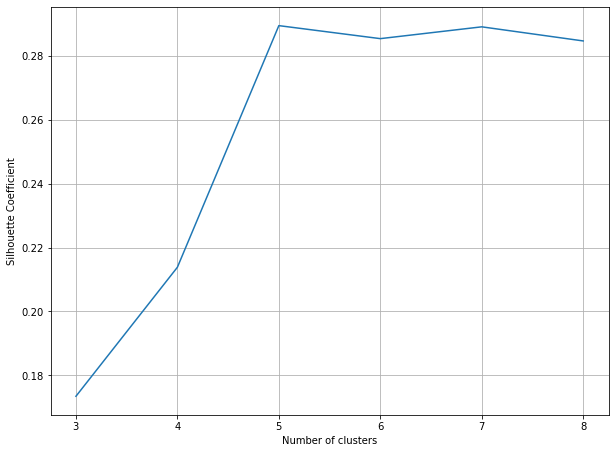

In [145]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

Checking segment distribution for different clusters

In [149]:
df_new.cluster_7.value_counts()/sum(df_new.cluster_7.value_counts())

6    0.254087
3    0.253406
0    0.182561
1    0.134877
2    0.092643
5    0.049728
4    0.032698
Name: cluster_7, dtype: float64

In [150]:
df_new.cluster_3.value_counts()/sum(df_new.cluster_3.value_counts())

2    0.595368
0    0.268392
1    0.136240
Name: cluster_3, dtype: float64

In [151]:
## Profiling
size=pd.concat([pd.Series(df_new.cluster_3.size), pd.Series.sort_index(df_new.cluster_3.value_counts()), pd.Series.sort_index(df_new.cluster_4.value_counts()),
           pd.Series.sort_index(df_new.cluster_5.value_counts()), pd.Series.sort_index(df_new.cluster_6.value_counts()),
           pd.Series.sort_index(df_new.cluster_7.value_counts()), pd.Series.sort_index(df_new.cluster_8.value_counts())])

In [152]:
size

0    1468
0     394
1     200
2     874
0     395
1     180
2     820
3      73
0     800
1     166
2     139
3      73
4     290
0     710
1      55
2     225
3      73
4     268
5     137
0     268
1     198
2     136
3     372
4      48
5      73
6     373
0     238
1      45
2     185
3     270
4      73
5     136
6     247
7     274
dtype: int64

In [157]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/df_new.cluster_3.size, columns=['Seg_Pct'])

In [158]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.268392,0.13624,0.595368,0.269074,0.122616,0.558583,0.049728,0.544959,0.113079,...,0.049728,0.254087,0.162125,0.030654,0.126022,0.183924,0.049728,0.092643,0.168256,0.186649


In [159]:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,1468.0,394.000000,200.00000,874.000000,395.000000,180.000000,820.000000,73.000000,800.000000,166.000000,...,73.000000,373.000000,238.000000,45.000000,185.000000,270.000000,73.000000,136.000000,247.000000,274.000000
Seg_Pct,1.0,0.268392,0.13624,0.595368,0.269074,0.122616,0.558583,0.049728,0.544959,0.113079,...,0.049728,0.254087,0.162125,0.030654,0.126022,0.183924,0.049728,0.092643,0.168256,0.186649


In [160]:
df_new.apply(np.mean).T

Quantity                   1816.003065
Avg_Price                 21514.961388
Delivery_Charges           4191.911275
Discount_pct               8193.768392
GST                          56.262033
Tenure_Months                25.912125
gender_M                      0.363760
location_Chicago              0.310627
location_New Jersey           0.101499
location_New York             0.220708
location_Washington DC        0.051090
cluster_3                     1.326975
cluster_4                     1.388965
cluster_5                     1.241826
cluster_6                     1.690054
cluster_7                     2.984332
cluster_8                     3.812670
dtype: float64

In [161]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([df_new.apply(lambda x: x.mean()).T, df_new.groupby('cluster_3').apply(lambda x: x.mean()).T, df_new.groupby('cluster_4').apply(lambda x: x.mean()).T,
          df_new.groupby('cluster_5').apply(lambda x: x.mean()).T, df_new.groupby('cluster_6').apply(lambda x: x.mean()).T,
          df_new.groupby('cluster_7').apply(lambda x: x.mean()).T, df_new.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [162]:
Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Quantity,1816.003065,1143.106599,6614.547500,1021.280320,1169.954430,6804.385556,1044.509756,1677.713699,1080.011250,7083.984337,...,1677.713699,1027.536193,1005.491597,10901.382222,4806.909189,940.559259,1677.713699,1212.367647,964.097166,975.572993
Avg_Price,21514.961388,15147.287763,68160.499165,13711.478381,15149.984756,70443.279072,13795.888934,22017.810679,14488.560108,71792.583030,...,22017.810679,13587.603831,13554.449450,105571.558373,53311.483385,13092.544514,22017.810679,13664.763303,11968.916876,13823.512112
Delivery_Charges,4191.911275,2771.017487,14255.416156,2529.589967,2783.249646,14766.880896,2568.409172,3975.452877,2659.071975,15305.632417,...,3975.452877,2496.651126,2369.108151,23603.126693,11074.314166,2341.129222,3975.452877,2445.439118,2107.611862,2567.578066
Discount_pct,8193.768392,5649.137056,26325.060000,5191.853547,5664.000000,27296.733333,5245.463415,7896.986301,5467.200000,27959.349398,...,7896.986301,5077.319035,5019.831933,42349.600000,20427.243243,5022.222222,7896.986301,5073.529412,4497.813765,5166.131387
GST,56.262033,38.425279,180.970820,35.765378,38.567089,187.707911,36.125244,54.089589,37.393250,192.629783,...,54.089589,34.516568,33.982017,292.526311,140.577189,34.579778,54.089589,35.087500,30.880567,35.218978
Tenure_Months,25.912125,26.345178,25.710000,25.763158,26.336709,25.605556,25.846341,25.109589,26.142500,26.174699,...,25.109589,26.597855,26.554622,25.377778,25.540541,26.500000,25.109589,23.882353,25.368421,26.824818
gender_M,0.363760,0.370558,0.380000,0.356979,0.369620,0.372222,0.350000,0.465753,0.361250,0.361446,...,0.465753,0.367292,0.000000,0.333333,0.362162,0.351852,0.465753,0.360294,0.000000,1.000000
location_Chicago,0.310627,1.000000,0.310000,0.000000,1.000000,0.338889,0.000000,0.000000,0.492500,0.373494,...,0.000000,1.000000,1.000000,0.422222,0.313514,0.000000,0.000000,0.000000,0.000000,0.514599
location_New Jersey,0.101499,0.000000,0.065000,0.155606,0.000000,0.072222,0.165854,0.000000,0.000000,0.060241,...,0.000000,0.000000,0.000000,0.044444,0.059459,0.000000,0.000000,1.000000,0.000000,0.000000
location_New York,0.220708,0.000000,0.235000,0.316934,0.000000,0.238889,0.342683,0.000000,0.000000,0.204819,...,0.000000,0.000000,0.000000,0.222222,0.237838,1.000000,0.000000,0.000000,0.000000,0.000000


In [163]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)

In [164]:
Profling_output_final

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,1468.000000,394.000000,200.000000,874.000000,395.000000,180.000000,820.000000,73.000000,800.000000,166.000000,...,73.000000,373.000000,238.000000,45.000000,185.000000,270.000000,73.000000,136.000000,247.000000,274.000000
Seg_Pct,1.000000,0.268392,0.136240,0.595368,0.269074,0.122616,0.558583,0.049728,0.544959,0.113079,...,0.049728,0.254087,0.162125,0.030654,0.126022,0.183924,0.049728,0.092643,0.168256,0.186649
Quantity,1816.003065,1143.106599,6614.547500,1021.280320,1169.954430,6804.385556,1044.509756,1677.713699,1080.011250,7083.984337,...,1677.713699,1027.536193,1005.491597,10901.382222,4806.909189,940.559259,1677.713699,1212.367647,964.097166,975.572993
Avg_Price,21514.961388,15147.287763,68160.499165,13711.478381,15149.984756,70443.279072,13795.888934,22017.810679,14488.560108,71792.583030,...,22017.810679,13587.603831,13554.449450,105571.558373,53311.483385,13092.544514,22017.810679,13664.763303,11968.916876,13823.512112
Delivery_Charges,4191.911275,2771.017487,14255.416156,2529.589967,2783.249646,14766.880896,2568.409172,3975.452877,2659.071975,15305.632417,...,3975.452877,2496.651126,2369.108151,23603.126693,11074.314166,2341.129222,3975.452877,2445.439118,2107.611862,2567.578066
Discount_pct,8193.768392,5649.137056,26325.060000,5191.853547,5664.000000,27296.733333,5245.463415,7896.986301,5467.200000,27959.349398,...,7896.986301,5077.319035,5019.831933,42349.600000,20427.243243,5022.222222,7896.986301,5073.529412,4497.813765,5166.131387
GST,56.262033,38.425279,180.970820,35.765378,38.567089,187.707911,36.125244,54.089589,37.393250,192.629783,...,54.089589,34.516568,33.982017,292.526311,140.577189,34.579778,54.089589,35.087500,30.880567,35.218978
Tenure_Months,25.912125,26.345178,25.710000,25.763158,26.336709,25.605556,25.846341,25.109589,26.142500,26.174699,...,25.109589,26.597855,26.554622,25.377778,25.540541,26.500000,25.109589,23.882353,25.368421,26.824818
gender_M,0.363760,0.370558,0.380000,0.356979,0.369620,0.372222,0.350000,0.465753,0.361250,0.361446,...,0.465753,0.367292,0.000000,0.333333,0.362162,0.351852,0.465753,0.360294,0.000000,1.000000
location_Chicago,0.310627,1.000000,0.310000,0.000000,1.000000,0.338889,0.000000,0.000000,0.492500,0.373494,...,0.000000,1.000000,1.000000,0.422222,0.313514,0.000000,0.000000,0.000000,0.000000,0.514599


In [165]:
#Profling_output_final.columns
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [166]:
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,1468.000000,394.000000,200.000000,874.000000,395.000000,180.000000,820.000000,73.000000,800.000000,166.000000,...,73.000000,373.000000,238.000000,45.000000,185.000000,270.000000,73.000000,136.000000,247.000000,274.000000
Seg_Pct,1.000000,0.268392,0.136240,0.595368,0.269074,0.122616,0.558583,0.049728,0.544959,0.113079,...,0.049728,0.254087,0.162125,0.030654,0.126022,0.183924,0.049728,0.092643,0.168256,0.186649
Quantity,1816.003065,1143.106599,6614.547500,1021.280320,1169.954430,6804.385556,1044.509756,1677.713699,1080.011250,7083.984337,...,1677.713699,1027.536193,1005.491597,10901.382222,4806.909189,940.559259,1677.713699,1212.367647,964.097166,975.572993
Avg_Price,21514.961388,15147.287763,68160.499165,13711.478381,15149.984756,70443.279072,13795.888934,22017.810679,14488.560108,71792.583030,...,22017.810679,13587.603831,13554.449450,105571.558373,53311.483385,13092.544514,22017.810679,13664.763303,11968.916876,13823.512112
Delivery_Charges,4191.911275,2771.017487,14255.416156,2529.589967,2783.249646,14766.880896,2568.409172,3975.452877,2659.071975,15305.632417,...,3975.452877,2496.651126,2369.108151,23603.126693,11074.314166,2341.129222,3975.452877,2445.439118,2107.611862,2567.578066
Discount_pct,8193.768392,5649.137056,26325.060000,5191.853547,5664.000000,27296.733333,5245.463415,7896.986301,5467.200000,27959.349398,...,7896.986301,5077.319035,5019.831933,42349.600000,20427.243243,5022.222222,7896.986301,5073.529412,4497.813765,5166.131387
GST,56.262033,38.425279,180.970820,35.765378,38.567089,187.707911,36.125244,54.089589,37.393250,192.629783,...,54.089589,34.516568,33.982017,292.526311,140.577189,34.579778,54.089589,35.087500,30.880567,35.218978
Tenure_Months,25.912125,26.345178,25.710000,25.763158,26.336709,25.605556,25.846341,25.109589,26.142500,26.174699,...,25.109589,26.597855,26.554622,25.377778,25.540541,26.500000,25.109589,23.882353,25.368421,26.824818
gender_M,0.363760,0.370558,0.380000,0.356979,0.369620,0.372222,0.350000,0.465753,0.361250,0.361446,...,0.465753,0.367292,0.000000,0.333333,0.362162,0.351852,0.465753,0.360294,0.000000,1.000000
location_Chicago,0.310627,1.000000,0.310000,0.000000,1.000000,0.338889,0.000000,0.000000,0.492500,0.373494,...,0.000000,1.000000,1.000000,0.422222,0.313514,0.000000,0.000000,0.000000,0.000000,0.514599
